In [1]:
# env = ag , python 3.11.11

In [116]:
import pandas as pd
import numpy as np
import autogluon
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt



# Dataset

## Rossmann Store Sales
Forcaste the sales column. (number of Sales) Regression.


It is not imbalanced but there are only 9 columns. 

In [117]:
data = pd.read_csv("/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Data/rossmann-store-sales/train.csv")
data

/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_40418/4213327779.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("/Users/sepideghorbanian/Documents/Semester_5/Research_Project/Data/rossmann-store-sales/train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [119]:
data["StateHoliday"].value_counts()

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64

## Startified

### Split the data into 5 datasets startified.

The problem with regression is that because it has continues values for the label it is not possible to easily do the startification (like in classification). 
The trick is to first split it into different bins (pandas qcut: Quantile-based discretization function , first 10% of the values, second 10% of the values and so on). Then use those bins for startification. Basically it makes sure to take the same amount of records from each bin. Use Kfold for making the 5 datasets and then train_test_split for splitiing each of those datasets.


In [120]:
y = data["Sales"]
X = data.drop("Sales" , axis = 1)

In [121]:
# Quantile bins for stratification, turn them to categories based on their index. (Kfold needs y to be category)
y_bins = pd.qcut(y, q=10, duplicates='drop')
y_bins = y_bins.cat.codes

In [122]:
# Create 5 stratified subsets
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

splits = []
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_bins)):
    X_subset = X.iloc[test_idx]
    y_subset = y.iloc[test_idx]
    splits.append((X_subset, y_subset))
    print(f"Subset {fold+1}: {X_subset.shape}")

Subset 1: (203442, 8)
Subset 2: (203442, 8)
Subset 3: (203442, 8)
Subset 4: (203442, 8)
Subset 5: (203441, 8)


In [123]:
datasets = []  # Store (X_train, X_test, y_train, y_test) for each subset

for i, (X_sub, y_sub) in enumerate(splits):
    # Re-bin within subset for stratification
    y_bins_sub = pd.qcut(y_sub, q=10, duplicates='drop')
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_sub, y_sub, test_size=0.2, stratify=y_bins_sub, random_state=42
    )
    
    datasets.append((X_train, X_test, y_train, y_test))
    print(f"Subset {i+1}: Train={X_train.shape}, Test={X_test.shape}")

Subset 1: Train=(162753, 8), Test=(40689, 8)
Subset 2: Train=(162753, 8), Test=(40689, 8)
Subset 3: Train=(162753, 8), Test=(40689, 8)
Subset 4: Train=(162753, 8), Test=(40689, 8)
Subset 5: Train=(162752, 8), Test=(40689, 8)


In [156]:
X_train_1, X_test_1, y_train_1, y_test_1 = datasets[0]
X_train_2, X_test_2, y_train_2, y_test_2 = datasets[1]
X_train_3, X_test_3, y_train_3, y_test_3 = datasets[2]
X_train_4, X_test_4, y_train_4, y_test_4 = datasets[3]
X_train_5, X_test_5, y_train_5, y_test_5 = datasets[4]
# Use the fifth one as the new data for testing

In [157]:
X_main_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4 ]).reset_index(drop=True)
y_main_train = pd.concat([y_train_1, y_train_2, y_train_3, y_train_4 ]).reset_index(drop=True)
X_main_test = pd.concat([X_test_1, X_test_2, X_test_3, X_test_4]).reset_index(drop=True)
y_main_test = pd.concat([y_test_1, y_test_2, y_test_3, y_test_4]).reset_index(drop=True)

In [158]:
main_train_df = X_main_train.copy()
main_train_df['Sales'] = y_main_train
main_train_df

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,44,2,2014-05-06,763,1,1,0,0,7076
1,346,2,2014-07-29,663,1,1,0,1,8129
2,331,7,2014-09-28,0,0,0,0,0,0
3,572,7,2013-11-17,0,0,0,0,0,0
4,1014,3,2015-07-15,1234,1,1,0,1,12288
...,...,...,...,...,...,...,...,...,...
651007,310,2,2013-05-14,860,1,1,0,0,9827
651008,667,7,2014-07-27,0,0,0,0,0,0
651009,990,1,2013-02-25,458,1,0,0,0,4158
651010,969,5,2013-09-13,582,1,1,0,0,3506


In [159]:
main_test_df = X_main_test.copy()
main_test_df['Sales'] = y_main_test
main_test_df

,Store,DayOfWeek,Date,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,448,5,2014-09-26,698,1,0,0,0,7418
1,1113,2,2013-07-09,606,1,0,0,1,5258
2,408,7,2013-02-10,0,0,0,0,0,0
3,410,1,2014-02-03,1206,1,1,0,0,11920
4,193,1,2013-11-11,764,1,0,0,0,4371
...,...,...,...,...,...,...,...,...,...
162751,839,5,2013-02-22,743,1,1,0,0,6068
162752,874,5,2013-11-22,426,1,1,0,0,4259
162753,140,3,2014-08-27,898,1,0,0,1,6783
162754,799,1,2014-09-01,1145,1,1,0,0,14429


In [160]:
'''
Trained for more than 120 min
label = 'Sales'
predictor= TabularPredictor(label=label, path="AutogluonModels/" ).fit(main_train_df,  presets="best")
'''

'\nTrained for more than 120 min\nlabel = \'Sales\'\npredictor= TabularPredictor(label=label, path="AutogluonModels/" ).fit(main_train_df,  presets="best")\n'

In [161]:
# predictor = TabularPredictor.load("AutogluonModels/")

In [162]:
# predictor.leaderboard(silent=True)

### Evaluation Metrics

| Metric                                | Ideal Direction        | Meaning                                                                                                                                          |
| ------------------------------------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------ |
| **RMSE (Root Mean Squared Error)**    | ↓ lower = better       | Measures the *typical deviation* between predicted and actual values, penalizing large errors strongly. Same unit as the target (here: “Sales”). |
| **MAE (Mean Absolute Error)**         | ↓ lower = better       | Measures the *average absolute difference* between prediction and truth. More robust to outliers than RMSE.                                      |
| **R² (Coefficient of Determination)** | ↑ closer to 1 = better | Measures how much of the variance in your target is explained by the model (1 = perfect fit, 0 = no better than predicting the mean).            |
| **Pearson r**                         | ↑ closer to 1 = better | Measures *linear correlation* between predicted and true values. Often very close to √R² for linear relationships.                               |


In [163]:
# Evaluate on all the test data takes about 16 min
# The negative values are because AutoGluon uses the same logic for regression and classification and in classification bigger is better, 
# but in regression RMSE and the errors smaller is better therefore it uses negative to sustain the logic. But we know in reality errors are like distance and are always positive.
# RMSE(Root Mean Squared Error): Off by ~524 sales units on average. Compare it to the scale of the target variable. -> Good
# MAE: Average absolute deviation — usually smaller than RMSE (good).
# R²: Excellent! Model explains about 95% of the variation in sales.
# Pearson r: Very strong correlation between predicted and true values.

# performance_main = predictor.evaluate(main_test_df)
# performance_main

In [164]:
# To find out whether the values of the prediction are good or not, we can compare them with the scale of true labels. 
# We see that mean is 5774 and the model is only off by ‍around 525 units (less than 10%) therefore the results are really good.

# main_test_df["Sales"].describe()

In [165]:
# preds_1 = predictor.predict(X_test_1)
# preds_1

In [166]:
# df_1 = X_test_1 
# df_1["Sales"] = y_test_1
# eval_1 = predictor.evaluate(df_1)
# eval_1

In [167]:
'''
plt.scatter(y_test_1, preds_1, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()
'''

'\nplt.scatter(y_test_1, preds_1, alpha=0.5)\nplt.xlabel("Actual Sales")\nplt.ylabel("Predicted Sales")\nplt.title("Predicted vs Actual Sales")\nplt.show()\n'

In [168]:
'''
df_2 = X_test_2
df_2["Sales"] = y_test_2
small_df = df_2[1000:1100]
small_df

'''

'\ndf_2 = X_test_2\ndf_2["Sales"] = y_test_2\nsmall_df = df_2[1000:1100]\nsmall_df\n\n'

In [169]:
# eval_small = predictor.evaluate(small_df)
# eval_small

In [170]:
# small_df["Sales"].describe()

In [174]:

#Trained for 5 min
# I had to disable the stacking that AutoGluon does for best quality due to the time limit.
label = 'Sales'
predictor_5min= TabularPredictor(label=label, path="AutogluonModels_5min/" ).fit(main_train_df,  presets="best" , time_limit = 300 , dynamic_stacking=False)


Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       2.16 GB / 8.00 GB (27.0%)
Disk Space Avail:   53.33 GB / 228.27 GB (23.4%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min"
Train Data Rows:    651012
Train Data Columns: 8
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int 

In [175]:
predictor_5min = TabularPredictor.load("AutogluonModels_5min/")

In [176]:
predictor_5min.leaderboard(silent=True)

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-1182.215264,root_mean_squared_error,164.520180,268.078002,0.015585,0.564433,3,True,5
1,LightGBMXT_BAG_L2,-1182.548513,root_mean_squared_error,164.504596,267.513569,39.927297,82.019467,2,True,4
2,LightGBMXT_BAG_L1,-1194.169731,root_mean_squared_error,124.338448,180.887950,124.338448,180.887950,1,True,1
3,WeightedEnsemble_L2,-1194.169731,root_mean_squared_error,124.344982,181.145531,0.006534,0.257581,2,True,3
4,LightGBM_BAG_L1,-3683.523843,root_mean_squared_error,0.238851,4.606152,0.238851,4.606152,1,True,2


In [200]:
big_df = pd.concat([X_test_1,X_test_2,X_test_3,X_test_4,X_test_5])
big_df["Sales"] = pd.concat([y_test_1,y_test_2, y_test_3, y_test_4, y_test_5])
small_df = X_test_3[1600:2000]
small_df["Sales"] = y_test_3[1600:2000]

/var/folders/m_/m50wq84x1gv7lmgz099xvzd80000gn/T/ipykernel_40418/1637633621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["Sales"] = y_test_3[1600:2000]


In [204]:
eval_small_df_5min = predictor_5min.evaluate(small_df)
eval_small_df_5min

{'root_mean_squared_error': np.float64(-1121.6071705922457),
 'mean_squared_error': -1258002.75,
 'mean_absolute_error': -737.8386840820312,
 'r2': 0.926180362701416,
 'pearsonr': 0.9625334021532336,
 'median_absolute_error': -557.424560546875}

In [ ]:
eval_big_df_5min = predictor_5min.evaluate(big_df)
eval_big_df_5min

In [191]:
small_df["Sales"].describe()

count      400.000000
mean      5441.095000
std       4005.717502
min          0.000000
25%       3314.000000
50%       5494.500000
75%       7527.500000
max      25880.000000
Name: Sales, dtype: float64

In [192]:
big_df["Sales"].describe()

count    162752.000000
mean       5777.217128
std        3853.712022
min           0.000000
25%        3724.000000
50%        5744.000000
75%        7859.000000
max       38484.000000
Name: Sales, dtype: float64

In [143]:
small_df_label = small_df["Sales"]
small_df.drop("Sales" , axis = 1)
pred_small_5min = predictor_5min.predict(small_df)
pred_small_5min

10000     6025.039551
10001        6.144671
10002     8949.804688
10003     5804.695801
10004     8951.258789
             ...     
100195    4965.300781
100196    6795.276855
100197    5496.699219
100198    8380.533203
100199    6796.538574
Name: Sales, Length: 90200, dtype: float32

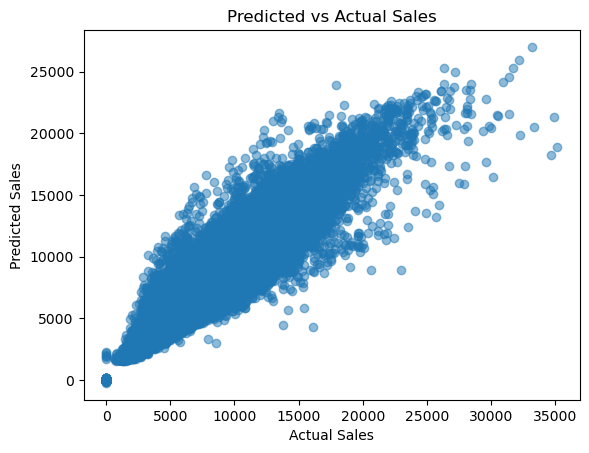

In [144]:
plt.scatter(small_df_label, pred_small_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [145]:
big_df_label = big_df["Sales"]
big_df.drop("Sales" , axis = 1)
pred_big_5min = predictor_5min.predict(big_df)
pred_big_5min

0          5779.958984
1          5611.436035
2             6.449382
3         12096.588867
4          6282.105957
              ...     
203440     7044.528320
203441     6424.984863
203442     7127.409180
203443       10.428277
203444     7424.416992
Name: Sales, Length: 203445, dtype: float32

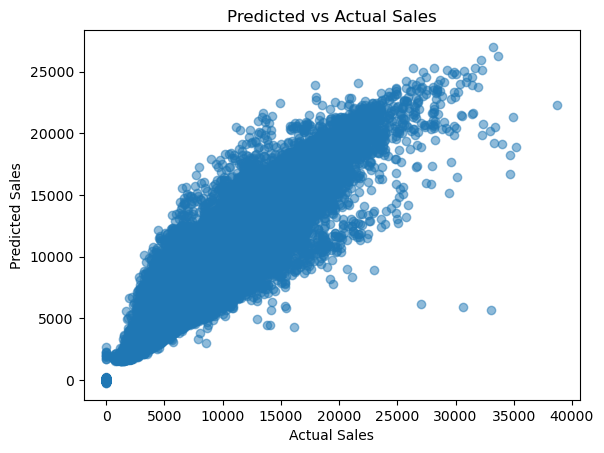

In [146]:
plt.scatter(big_df_label, pred_big_5min, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Predicted vs Actual Sales")
plt.show()

In [37]:
# The results still seem to be good!!!
# But it is worse than before
# It seems like the 5 min trained model is performing worse in the small dataset comparing to the big dataset. Or maybe not. Analyze properly.

## Non-Startified

In [35]:
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [36]:
n_splits = 5

split_size = len(data) // n_splits

data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

datasets = []
for i in range(n_splits):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < n_splits - 1 else len(data_shuffled)
    datasets.append(data_shuffled.iloc[start_idx:end_idx].reset_index(drop=True))

In [38]:
datasets[0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,616,7,2015-05-24,0,0,0,0,0,0
1,592,2,2013-03-26,5548,710,1,1,0,1
2,526,6,2013-09-14,7467,1150,1,0,0,0
3,601,2,2013-07-23,3360,323,1,0,0,1
4,953,1,2014-12-15,11414,853,1,1,0,0
...,...,...,...,...,...,...,...,...,...
203436,430,3,2015-05-13,10632,883,1,0,0,0
203437,370,6,2014-02-01,8822,715,1,0,0,0
203438,199,1,2013-08-26,11716,833,1,1,0,0
203439,1069,6,2015-06-27,3375,406,1,0,0,0


In [ ]:
splits = {}

for i, ds in enumerate(datasets):
    train, test = train_test_split(ds, test_size=0.2, random_state=42)  
    splits[f'dataset_{i+1}'] = {'train': train.reset_index(drop=True),
                                 'test': test.reset_index(drop=True)}

In [66]:
X_train_1, X_test_1 = splits['dataset_1']['train'] , splits['dataset_1']['test'] 
X_train_2, X_test_2 = splits['dataset_2']['train'] , splits['dataset_2']['test'] 
X_train_3, X_test_3= splits['dataset_3']['train'] , splits['dataset_3']['test'] 
X_train_4, X_test_4= splits['dataset_4']['train'] , splits['dataset_4']['test'] 
X_train_5, X_test_5= splits['dataset_5']['train'] , splits['dataset_5']['test'] 

In [67]:
X_main_train = pd.concat([X_train_1, X_train_2, X_train_3, X_train_4 , X_train_5]).reset_index(drop=True)
X_main_test = pd.concat([X_test_1, X_test_2, X_test_3, X_test_4, X_test_5]).reset_index(drop=True)

In [68]:
label = 'Sales'
predictor_5min_non= TabularPredictor(label=label, path="AutogluonModels_5min_non/" ).fit(X_main_train,  presets="best" , time_limit = 300 , dynamic_stacking=False)

Preset alias specified: 'best' maps to 'best_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.11.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.4.0: Fri Mar 15 00:19:22 PDT 2024; root:xnu-10063.101.17~1/RELEASE_ARM64_T8112
CPU Count:          8
Memory Avail:       2.29 GB / 8.00 GB (28.6%)
Disk Space Avail:   54.43 GB / 228.27 GB (23.8%)
Presets specified: ['best']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "/Users/sepideghorbanian/Documents/Semester_5/Research_Project/AutogluonModels_5min_non"
Train Data Rows:    813764
Train Data Columns: 8
Label Column:       Sales
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == 

In [69]:
preds = predictor_5min_non.evaluate(X_main_test)
preds

{'root_mean_squared_error': np.float64(-1186.0820563439006),
 'mean_squared_error': -1406790.625,
 'mean_absolute_error': -799.689453125,
 'r2': 0.9043170213699341,
 'pearsonr': 0.9509675984957358,
 'median_absolute_error': -579.5908203125}

In [70]:
X_main_test["Sales"].describe()

count    203445.000000
mean       5770.776102
std        3834.409019
min           0.000000
25%        3733.000000
50%        5745.000000
75%        7854.000000
max       38722.000000
Name: Sales, dtype: float64

In [76]:
small_df = pd.merge([X_test_1[100:150] ,X_test_2[100:150] ,X_test_3[100:150] ,X_test_4[100:150] , X_test_5[100:150]])
preds_small_df = predictor_5min_non.evaluate(small_df)
preds_small_df

TypeError: merge() missing 1 required positional argument: 'right'

In [ ]:
small_df["Sales"].describe()

count      500.000000
mean      5833.114000
std       3923.584695
min          0.000000
25%       3737.250000
50%       5689.000000
75%       7759.000000
max      24895.000000
Name: Sales, dtype: float64